In [86]:
#importing library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

In [87]:
#load the dataset
df=pd.read_csv('../input/malicious-and-benign-websites/dataset.csv')
df

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,M4_48,194,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1777,M4_41,198,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,2,124,0,0,0.0,1
1778,B0_162,201,34,utf-8,Apache/2.2.16 (Debian),8904.0,US,FL,15/02/1999 0:00,15/07/2015 0:00,...,2,6,6631,87,89,132181,6945,87,4.0,0
1779,B0_1152,234,34,ISO-8859-1,cloudflare-nginx,NaN,US,CA,1/04/1998 0:00,9/12/2016 0:00,...,0,0,0,0,0,0,0,0,0.0,0


In [88]:
#getting information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1781 non-null   object 
 4   SERVER                     1780 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1781 non-null   object 
 7   WHOIS_STATEPRO             1781 non-null   object 
 8   WHOIS_REGDATE              1781 non-null   object 
 9   WHOIS_UPDATED_DATE         1781 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

There are null  value in the dataset

In [89]:
#checking for null value
df.isna().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [90]:
#creating onehot encoder 
def onehot_encode(df,column_dict):
    df=df.copy()
    for column,prefix in column_dict.items():
        dummies=pd.get_dummies(df[column],prefix=prefix)
        df=pd.concat([df,dummies],axis=1)
        df=df.drop(column,axis=1)
    return df

In [103]:
#preprocessing 
def preprocess_inputs(df):
    df=df.copy()
    #Dropping url column
    df=df.drop("URL",axis=1)
    #Extracting datetime features
    for column in ['WHOIS_REGDATE','WHOIS_UPDATED_DATE']:
        df[column]=pd.to_datetime(df[column],errors='coerce')
    df['Reg_year']=df['WHOIS_REGDATE'].apply(lambda x:x.year)
    df['Reg_month']=df['WHOIS_REGDATE'].apply(lambda x:x.month)
    df['Reg_day']=df['WHOIS_REGDATE'].apply(lambda x:x.day)
    df['Reg_hour']=df['WHOIS_REGDATE'].apply(lambda x:x.hour)
    df['Reg_minute']=df['WHOIS_REGDATE'].apply(lambda x:x.minute)
    df['Upd_year']=df['WHOIS_REGDATE'].apply(lambda x:x.year)
    df['Upd_month']=df['WHOIS_REGDATE'].apply(lambda x:x.month)
    df['Upd_day']=df['WHOIS_REGDATE'].apply(lambda x:x.day)
    df['Upd_hour']=df['WHOIS_REGDATE'].apply(lambda x:x.hour)
    df['Upd_minute']=df['WHOIS_REGDATE'].apply(lambda x:x.minute)
    df=df.drop(['WHOIS_REGDATE','WHOIS_UPDATED_DATE'],axis=1)
    for column in ['CHARSET','SERVER','WHOIS_COUNTRY','WHOIS_STATEPRO']:
        df[column]=df[column].apply(lambda x:x.lower() if str(x)!='nan' else x)
    df=onehot_encode(
            df,
            column_dict={
                "CHARSET":'CH',
                "SERVER":'SV',
                'WHOIS_COUNTRY':'WC',
                'WHOIS_STATEPRO':"WS"   
            }
    )
    missing_value_columns=df.columns[df.isna().sum()>0]
    for column in missing_value_columns:
        df[column]=df[column].fillna(df[column].mean())
    #Spliting in x and y
    y=df['Type'].copy()
    x=df.drop('Type',axis=1).copy()
    #train_test_split
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=1)
    
    #Scaling the data
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=pd.DataFrame(scaler.transform(x_train),columns=x.columns)
    x_test= pd.DataFrame(scaler.transform(x_test),columns=x.columns)
    return x_train,x_test,y_train,y_test

In [104]:
x_train,x_test,y_train,y_test=preprocess_inputs(df)
x_train

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,...,WS_wc1n,WS_west midlands,WS_wi,WS_widestep@mail.ru,WS_wisconsin,WS_worcs,WS_wv,WS_zh,WS_zhejiang,WS_zug
0,-0.540717,-0.247609,-0.005396,-0.492012,-0.227663,-0.897190,-0.052119,-0.540641,-0.473132,-0.276002,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
1,-0.648930,-0.465490,-0.005396,-0.492012,-0.227663,-0.897190,-0.052119,-0.540641,-0.473132,-0.276002,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
2,0.180702,-0.029727,-0.391820,-0.492012,-0.227663,-0.897190,-0.052119,-0.540641,-0.473132,-0.276002,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
3,-0.288220,0.406036,-0.005396,1.068141,-0.227663,-0.301295,0.001251,1.015452,0.941702,0.930658,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
4,0.902121,1.277563,-0.005396,-0.492012,-0.227663,-0.897190,-0.052119,-0.540641,-0.421684,-0.273750,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,-0.432504,-0.683372,-0.395141,0.880923,-0.227663,-0.301295,0.008320,0.835903,0.710184,1.217755,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
1242,-0.252149,-0.247609,-0.005396,2.441076,-0.108957,1.486390,0.051064,2.391996,2.176467,3.310456,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
1243,-0.035724,-0.029727,-0.005396,-0.492012,-0.227663,-0.897190,-0.052119,-0.540641,-0.473132,-0.276002,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341
1244,-0.865355,-0.683372,-0.005396,0.506486,0.207593,0.890495,0.003090,0.656354,0.350044,-0.066390,...,-0.049128,-0.028341,-0.028341,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341,-0.040096,-0.028341


# Training the model

In [106]:
model=LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [107]:
model.score(x_test,y_test)

0.9570093457943926

In [109]:
y_test.value_counts()

0    474
1     61
Name: Type, dtype: int64

In [113]:
#confusion matrix
cm=confusion_matrix(y_true,y_pred)
print(cm)

[[465   9]
 [ 14  47]]


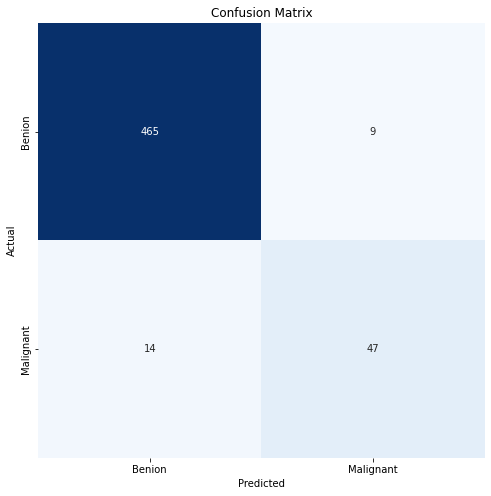

In [117]:
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,vmin=0,fmt='g',cmap='Blues',cbar=False)
plt.xticks(np.arange(2)+0.5,['Benion','Malignant'])
plt.yticks(np.arange(2)+0.5,['Benion','Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [110]:
y_train.value_counts()

0    1091
1     155
Name: Type, dtype: int64

In [111]:
y_true=np.array(y_test)
y_pred=model.predict(x_test)

In [93]:
#checking for unique values in categorical column
column_dict={column:len(x[column].unique()) for column in x.select_dtypes('object').columns}

In [94]:
x.columns[x.isna().sum()>0]

Index([], dtype='object')

In [95]:
column_dict

{}

In [105]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Columns: 474 entries, URL_LENGTH to WS_zug
dtypes: float64(12), int64(11), uint8(451)
memory usage: 1.1 MB
